# Case I: Diamond silicon

## Step 1. Data collection
For diamond silicon, we collect the ACE potential dataset in a **hand-built** manner, using both rattling and AIMD ways.  
- **Rattle**: 300 structures in total, with random atomic displacement (std = 0.03 A) and lattice strain (+/- 2%). 
- **AIMD**: 1000 structures in total, by sampling 100 snapshots from 1000-step-AIMDs at 10 different tempertures (100-1000 K in 100 K increments) respectively. 

### A. Rattle

- Start with diamond silicon positioned at energy minimal: `./case1_Diamond_Silicon/CONTCAR`  
- Get supercell (2x2x2)
- Add random displacements
- Add random strains
- Write to `./case1_Diamond_Silicon/DataCollection/rattle/POSCAR`

In [51]:
import numpy as np
from ase.io import read, write
from hiphive.structure_generation import generate_rattled_structures, generate_mc_rattled_structures

# read the diamond Si structure
cSi = read('./case1_Diamond_Silicon/CONTCAR', format='vasp')
# get 2x2x2 supercell
cSi222 = cSi * [2, 2, 2]
# add random displacements
rattled_configs = generate_mc_rattled_structures(
    atoms=cSi222, 
    n_structures=300, 
    rattle_std=0.03, 
    d_min=0.67 * 2.368,     # 2/3 of the Si-Si bond length
)
# add random strains and write to files
for i, config in enumerate(rattled_configs):
    strains = (np.random.rand(3) - 0.5) * 0.04  # random strain of +/- 0.02
    config.set_cell(cSi222.get_cell() * (1 + strains))
    write(f'./case1_Diamond_Silicon/DataCollection/rattle/POSCAR/POSCAR{i}', config, format='vasp')
write('./case1_Diamond_Silicon/DataCollection/rattle/POSCAR/rattle.xyz', rattled_configs, format='extxyz')

- Perform DFT calibration. The DFT results (OUTCAR) are collected in `./case1_Diamond_Silicon/DataCollection/rattle/result`  

The precalculated OUTCAR files can be fetched from remote with the following:

In [ ]:
!wget https://zenodo.org/records/14642844/files/case1_OUTCAR_rattle.zip
!unzip -j case1_OUTCAR_rattle.zip -d ./case1_Diamond_Silicon/DataCollection/rattle/result
!mv ./case1_OUTCAR_rattle.zip ./cache

### B. AIMD

- Prepare VASP files and perform AIMD. Results are collected in `./case1_Diamond_Silicon/DataCollection/AIMD/result`  

The precalculated OUTCAR files can be fetched from remote with the following:

In [ ]:
!wget https://zenodo.org/records/14642844/files/case1_OUTCAR_AIMD.zip
!unzip -j case1_OUTCAR_AIMD.zip -d ./case1_Diamond_Silicon/DataCollection/AIMD/result
!mv ./case1_OUTCAR_AIMD.zip ./cache

### C. Combine

In [16]:
from ase.io import read, write

dir = './case1_Diamond_Silicon/DataCollection/AIMD/result'
dataset_MD = []

# rattle dataset
for i in range(300):
    atoms = read(f'./case1_Diamond_Silicon/DataCollection/rattle/result/OUTCAR-{str(i).zfill(3)}', format='vasp-out')
    dataset_MD.append(atoms)

# AIMD dataset
step_int = 10   # sample every step_int
for temp in list(range(100, 1000+1, 100)):
    MDtraj = read(f'{dir}/OUTCAR_{temp}K', format='vasp-out', index=':')
    dataset_MD += MDtraj[step_int-1::step_int]  # sample snapshots every step_int steps

# output
write(f'./case1_Diamond_Silicon/DataCollection/dataset.xyz', dataset_MD, format='extxyz')

## Step 2. ACE potential training

### A. Prepare dataset
Transfer the dataset format to `.gzip` for `pacemaker`

In [32]:
from ase.io import read
import pandas as pd

# read the dataset
dataset = read('./case1_Diamond_Silicon/DataCollection/dataset.xyz', ':')
print(dataset[0].todict().keys())
print(dataset[0].todict()['info'].keys())

# extract the energy and forces
energy_list = [data.todict()['info']['energy'] for data in dataset]
forces_list = [data.todict()['forces'] for data in dataset]
data = {
    'energy': energy_list,
    'forces': forces_list,
    'ase_atoms': dataset,
    'energy_corrected': energy_list,
}

# save the dataset as a pickle file for later usage in ACE
df = pd.DataFrame(data)
df.to_pickle('./case1_Diamond_Silicon/MLIP_develop/dataset.pckl.gzip', compression='gzip', protocol=4)

dict_keys(['numbers', 'positions', 'forces', 'cell', 'pbc', 'info'])
dict_keys(['energy', 'stress', 'free_energy'])


### B. Prepare model hyperparameters
One can interactively generate default `pacemaker` input file `input.yaml` by running:
```
pacemaker -t
```
and enter requested information. This will produce an `input.yaml` file. (Detailed in [here](https://pacemaker.readthedocs.io/en/latest/pacemaker/quickstart/))
Then put it in `./case1_Diamond_Silicon/MLIP_develop`

### C. Train ACE model
Run the fit under `./case1_Diamond_Silicon/MLIP_develop` by executing the command:
```
pacemaker input.yaml
```
After the fitting finished, the generated file `output_potential.yaml` can be used as the Python interface of the ACE potential via ASE calculator  

The pretrained ACE potential can be fetched from remote with the following:

In [ ]:
!wget https://zenodo.org/records/14642844/files/case1_ACEmodel.zip
!unzip -nj case1_ACEmodel.zip -d ./case1_Diamond_Silicon/MLIP_develop
!mv ./case1_ACEmodel.zip ./cache

## Step 3. Thermal conductivity calculation with MLIP acceleration 

### A. Run $\kappa$ with ACE potential

#### Define and relax 

In [1]:
# define structure
from ase.io import read
ase_atoms = read('./case1_Diamond_Silicon/CONTCAR', format='vasp')
ase_atoms.rattle(0.1)       # validate the optimizer by rattling the structure, not necessary for real calculation

# relax
from pyace import PyACECalculator
from ase.optimize.precon import PreconLBFGS, Exp
calc = PyACECalculator('./case1_Diamond_Silicon/MLIP_develop/output_potential.yaml')
ase_atoms.calc = calc
optimizer = PreconLBFGS(
    ase_atoms,
    variable_cell=True,     # relax both postions and cell
)
optimizer.run(fmax=1e-5)    # force convergence criteria

PreconLBFGS:   0  14:34:44      -42.226861       2.5938       0.0131


/home/ubuntu/software/anaconda3/envs/ace/lib/python3.9/site-packages/ase/optimize/precon/lbfgs.py:133: UserWarning: The system is likely too small to benefit from the standard preconditioner, hence it is disabled. To re-enable preconditioning, call `PreconLBFGS` by explicitly providing the kwarg `precon`
  warnings.warn('The system is likely too small to benefit from '
/home/ubuntu/software/anaconda3/envs/ace/lib/python3.9/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)
2025-01-14 14:34:44,867 - ase.utils.linesearcharmijo - INFO - a1 = 0.015, suff_dec = True


PreconLBFGS:   1  14:34:44      -42.677223       2.0877       0.0078


2025-01-14 14:34:44,870 - ase.utils.linesearcharmijo - INFO - a1 = 0.029, suff_dec = True


PreconLBFGS:   2  14:34:44      -42.802800       2.0752       0.0109


2025-01-14 14:34:44,875 - ase.utils.linesearcharmijo - INFO - a1 = 0.042, suff_dec = True


PreconLBFGS:   3  14:34:44      -42.897925       1.7275       0.0066


2025-01-14 14:34:44,880 - ase.utils.linesearcharmijo - INFO - a1 = 0.049, suff_dec = True


PreconLBFGS:   4  14:34:44      -43.046887       1.4868       0.0063


2025-01-14 14:34:44,886 - ase.utils.linesearcharmijo - INFO - a1 = 0.036, suff_dec = True


PreconLBFGS:   5  14:34:44      -43.139571       1.2636       0.0082


2025-01-14 14:34:44,893 - ase.utils.linesearcharmijo - INFO - a1 = 0.123, suff_dec = True


PreconLBFGS:   6  14:34:44      -43.175189       1.1936       0.0038


2025-01-14 14:34:44,899 - ase.utils.linesearcharmijo - INFO - a1 = 0.077, suff_dec = True


PreconLBFGS:   7  14:34:44      -43.234424       0.9374       0.0027


2025-01-14 14:34:44,905 - ase.utils.linesearcharmijo - INFO - a1 = 0.092, suff_dec = True


PreconLBFGS:   8  14:34:44      -43.271865       0.7673       0.0075


2025-01-14 14:34:44,912 - ase.utils.linesearcharmijo - INFO - a1 = 0.281, suff_dec = False
2025-01-14 14:34:44,916 - ase.utils.linesearcharmijo - INFO - a1 = 0.091, suff_dec = True


PreconLBFGS:   9  14:34:44      -43.281819       0.7455       0.0051


2025-01-14 14:34:44,922 - ase.utils.linesearcharmijo - INFO - a1 = 0.082, suff_dec = True


PreconLBFGS:  10  14:34:44      -43.299143       0.5999       0.0038


2025-01-14 14:34:44,928 - ase.utils.linesearcharmijo - INFO - a1 = 0.113, suff_dec = False
2025-01-14 14:34:44,931 - ase.utils.linesearcharmijo - INFO - a1 = 0.062, suff_dec = True


PreconLBFGS:  11  14:34:44      -43.308730       0.5285       0.0040


2025-01-14 14:34:44,935 - ase.utils.linesearcharmijo - INFO - a1 = 0.353, suff_dec = True


PreconLBFGS:  12  14:34:44      -43.319229       0.3284       0.0016


2025-01-14 14:34:44,938 - ase.utils.linesearcharmijo - INFO - a1 = 0.104, suff_dec = True


PreconLBFGS:  13  14:34:44      -43.329922       0.0591       0.0012


2025-01-14 14:34:44,945 - ase.utils.linesearcharmijo - INFO - a1 = 1.000, suff_dec = False
2025-01-14 14:34:44,949 - ase.utils.linesearcharmijo - INFO - a1 = 0.100, suff_dec = False
2025-01-14 14:34:44,953 - ase.utils.linesearcharmijo - INFO - a1 = 0.063, suff_dec = True


PreconLBFGS:  14  14:34:44      -43.330266       0.0426       0.0012


2025-01-14 14:34:44,958 - ase.utils.linesearcharmijo - INFO - a1 = 0.213, suff_dec = True


PreconLBFGS:  15  14:34:44      -43.330828       0.0330       0.0010


2025-01-14 14:34:44,964 - ase.utils.linesearcharmijo - INFO - a1 = 0.108, suff_dec = True


PreconLBFGS:  16  14:34:44      -43.331219       0.0671       0.0008


2025-01-14 14:34:44,971 - ase.utils.linesearcharmijo - INFO - a1 = 0.304, suff_dec = True


PreconLBFGS:  17  14:34:44      -43.331705       0.0512       0.0006


2025-01-14 14:34:44,977 - ase.utils.linesearcharmijo - INFO - a1 = 0.085, suff_dec = True


PreconLBFGS:  18  14:34:44      -43.332402       0.0261       0.0005


2025-01-14 14:34:44,981 - ase.utils.linesearcharmijo - INFO - a1 = 1.000, suff_dec = False
2025-01-14 14:34:44,983 - ase.utils.linesearcharmijo - INFO - a1 = 0.344, suff_dec = True


PreconLBFGS:  19  14:34:44      -43.332549       0.0317       0.0003


2025-01-14 14:34:44,986 - ase.utils.linesearcharmijo - INFO - a1 = 0.094, suff_dec = True


PreconLBFGS:  20  14:34:44      -43.332774       0.0204       0.0002


2025-01-14 14:34:44,993 - ase.utils.linesearcharmijo - INFO - a1 = 1.000, suff_dec = False
2025-01-14 14:34:44,996 - ase.utils.linesearcharmijo - INFO - a1 = 0.112, suff_dec = True


PreconLBFGS:  21  14:34:44      -43.332797       0.0211       0.0002


2025-01-14 14:34:45,003 - ase.utils.linesearcharmijo - INFO - a1 = 0.099, suff_dec = True


PreconLBFGS:  22  14:34:45      -43.332836       0.0167       0.0001


2025-01-14 14:34:45,009 - ase.utils.linesearcharmijo - INFO - a1 = 1.000, suff_dec = True


PreconLBFGS:  23  14:34:45      -43.332901       0.0016       0.0000


2025-01-14 14:34:45,015 - ase.utils.linesearcharmijo - INFO - a1 = 1.000, suff_dec = False
2025-01-14 14:34:45,019 - ase.utils.linesearcharmijo - INFO - a1 = 0.486, suff_dec = True


PreconLBFGS:  24  14:34:45      -43.332902       0.0010       0.0000


2025-01-14 14:34:45,025 - ase.utils.linesearcharmijo - INFO - a1 = 1.000, suff_dec = False
2025-01-14 14:34:45,027 - ase.utils.linesearcharmijo - INFO - a1 = 0.100, suff_dec = True


PreconLBFGS:  25  14:34:45      -43.332902       0.0007       0.0000


2025-01-14 14:34:45,032 - ase.utils.linesearcharmijo - INFO - a1 = 1.000, suff_dec = True


PreconLBFGS:  26  14:34:45      -43.332902       0.0001       0.0000


2025-01-14 14:34:45,037 - ase.utils.linesearcharmijo - INFO - a1 = 1.000, suff_dec = True


PreconLBFGS:  27  14:34:45      -43.332902       0.0001       0.0000


2025-01-14 14:34:45,042 - ase.utils.linesearcharmijo - INFO - a1 = 1.000, suff_dec = True


PreconLBFGS:  28  14:34:45      -43.332902       0.0000       0.0000


2025-01-14 14:34:45,048 - ase.utils.linesearcharmijo - INFO - a1 = 1.000, suff_dec = False
2025-01-14 14:34:45,051 - ase.utils.linesearcharmijo - INFO - a1 = 0.536, suff_dec = True


PreconLBFGS:  29  14:34:45      -43.332902       0.0000       0.0000


True

#### Get force constants

In [19]:
# generate list of displaced structures
import numpy as np
from phono3py import Phono3py
from phonopy.structure.atoms import PhonopyAtoms
unitcell = PhonopyAtoms(numbers=ase_atoms.numbers, 
                        scaled_positions=ase_atoms.get_scaled_positions(), 
                        cell=ase_atoms.cell.array) 
phono3py = Phono3py(unitcell=unitcell,
                    supercell_matrix=[3,3,3],               # 3x3x3 supercell
                    phonon_supercell_matrix=[3,3,3],)       # 3x3x3 supercell for 2nd force constants
phono3py.generate_displacements(distance=0.03,              # finite displacement distance, 0.03 A is a good choice in general
                                cutoff_pair_distance=6.21)  # cutoff distance for pair interaction, 6.21 A considers 5th nearest neighbors (included): 5.959 A gives the 5th nearest neighbor and 6.698 A gives the 6th nearest neighbor

# utility function to convert phonopy atoms to ase atoms
from ase.atoms import Atoms
def phonopy2ase(phon: PhonopyAtoms) -> Atoms:
    cell = phon.get_cell()
    pos = phon.get_positions()
    symbols = phon.get_chemical_symbols()
    return Atoms(symbols, pos, cell=cell, pbc=True)

# get 2nd force constants
supercell_fc2 = phonopy2ase(phono3py.phonon_supercell)      # transform to ase atoms to use ASE calculator
supercell_fc2.calc = calc
for dataset in phono3py.phonon_dataset['first_atoms']:
    supercell_fc2.positions[dataset['number']] += dataset['displacement']   # apply displacement
    dataset['forces'] = supercell_fc2.get_forces()                          # get forces
    supercell_fc2.positions[dataset['number']] -= dataset['displacement']   # reset positions
phono3py.produce_fc2(symmetrize_fc2=True)               
fc2 = phono3py.fc2

# get 3rd force constants
supercell_fc3 = phonopy2ase(phono3py.supercell)             # transform to ase atoms to use ASE calculator
supercell_fc3.calc = calc
for first_atom in phono3py.dataset['first_atoms']:
    supercell_fc3.positions[first_atom['number']] += first_atom['displacement']     # apply 1st displacement
    first_atom['forces'] = supercell_fc3.get_forces()
    for second_atom in first_atom['second_atoms']:
        if not second_atom['included']:
            second_atom['forces'] = np.zeros_like(supercell_fc3.positions)
        supercell_fc3.positions[second_atom['number']
                            ] += second_atom['displacement']                        # apply 2nd displacement
        second_atom['forces'] = supercell_fc3.get_forces()                          # get forces
        supercell_fc3.positions[second_atom['number']
                            ] -= second_atom['displacement']                        # reset 2nd displacement
    supercell_fc3.positions[first_atom['number']] -= first_atom['displacement']     # reset 1st displacement
phono3py.produce_fc3()
fc3 = phono3py.fc3

#### Calculate thermal conductivity

In [20]:
phono3py.mesh_numbers = [15]*3       # mesh numbers for q-point sampling
phono3py.init_phph_interaction()
phono3py.run_thermal_conductivity(
    temperatures=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 
    write_kappa=True, 
)
print(phono3py.thermal_conductivity.kappa)

import os
os.system('mv ./kappa* ./case1_Diamond_Silicon/TCCalculation')

[[[ 7.53144781e+02  7.53144668e+02  7.53144726e+02  2.33077355e-05
   -2.15103021e-05 -2.20746648e-04]
  [ 2.06603548e+02  2.06603517e+02  2.06603533e+02  6.39380498e-06
   -5.90073096e-06 -6.05554759e-05]
  [ 1.19895993e+02  1.19895975e+02  1.19895984e+02  3.71044740e-06
   -3.42430710e-06 -3.51415016e-05]
  [ 8.56473281e+01  8.56473154e+01  8.56473219e+01  2.65054652e-06
   -2.44614309e-06 -2.51032220e-05]
  [ 6.70069587e+01  6.70069487e+01  6.70069539e+01  2.07367894e-06
   -1.91376208e-06 -1.96397318e-05]
  [ 5.51727087e+01  5.51727004e+01  5.51727047e+01  1.70744183e-06
   -1.57576825e-06 -1.61711145e-05]
  [ 4.69518419e+01  4.69518349e+01  4.69518386e+01  1.45302888e-06
   -1.34097498e-06 -1.37615794e-05]
  [ 4.08922631e+01  4.08922570e+01  4.08922602e+01  1.26550177e-06
   -1.16790949e-06 -1.19855176e-05]
  [ 3.62333281e+01  3.62333227e+01  3.62333255e+01  1.12132070e-06
   -1.03484729e-06 -1.06199843e-05]
  [ 3.25361029e+01  3.25360980e+01  3.25361005e+01  1.00690186e-06
   -9.

0

### B. Plot

To get comparision of thermal calculation by ACE with results by DFT, we precalculate the termal conducitivity of diamond silicon using VASP, which can be fetched from remote with the following:

In [ ]:
!wget https://zenodo.org/records/14649880/files/case1_kappa_DFT.zip
!unzip -nj case1_kappa_DFT.zip -d ./case1_Diamond_Silicon/TCCalculation
!mv ./case1_kappa_DFT.zip ./cache

#### Calculate band and DOS using 2nd-FC

In [21]:
import phonopy
from phonopy import Phonopy
from phonopy.phonon.band_structure import get_band_qpoints_and_path_connections

# define k-path
# a useful tool to generate k-path: https://tools.materialscloud.org/seekpath/
path = [[
    [0, 0, 0], 
    [0.5, 0, 0.5],
    [0.375, 0.375, 0.75],
    [0, 0, 0], 
    [0.5, 0.5, 0.5],
]]
labels = ["$\\Gamma$", "X", "K", "$\\Gamma$", "L"]

####### ACE #######
phonon = Phonopy(
    phono3py._unitcell, 
    supercell_matrix=phono3py.supercell_matrix.diagonal(), 
    primitive_matrix='auto'
)
phonon.set_force_constants(phono3py.force_constants)
qpoints, connections = get_band_qpoints_and_path_connections(path, npoints=51)
phonon.run_band_structure(qpoints, path_connections=connections, labels=labels)
labels_ticks_ace = [0]
dist_ace, freq_ace = [], []
for i in range(len(phonon._band_structure._distances)):
    dist_ace.append(phonon._band_structure._distances[i])
    freq_ace.append(phonon._band_structure._frequencies[i])
    labels_ticks_ace.append(phonon._band_structure._distances[i][-1])
phonon.set_mesh([15,15,15])
phonon.run_total_dos()
dos_ace = phonon.get_total_dos_dict()

####### DFT #######
DFT_dir = './case1_Diamond_Silicon/TCCalculation/DFT-Si333'
phonon = phonopy.load(
    supercell_filename=f"{DFT_dir}/SPOSCAR",
    force_constants_filename=f"{DFT_dir}/fc2.hdf5"
)
qpoints, connections = get_band_qpoints_and_path_connections(path, npoints=51)
phonon.run_band_structure(qpoints, path_connections=connections, labels=labels)
labels_ticks_dft = [0]
dist_dft, freq_dft = [], []
for i in range(len(phonon._band_structure._distances)):
    dist_dft.append(phonon._band_structure._distances[i])
    freq_dft.append(phonon._band_structure._frequencies[i])
    labels_ticks_dft.append(phonon._band_structure._distances[i][-1])
phonon.set_mesh([15,15,15])
phonon.run_total_dos()
dos_dft = phonon.get_total_dos_dict()

#### Calculate kappa-temperature using 3rd-FC

In [22]:
####### ACE #######
kappa_ace = phono3py.thermal_conductivity.kappa[0][:-1, 0]
temp_ace = phono3py.thermal_conductivity.temperatures[:-1]
####### DFT #######
import h5py
f = h5py.File(f'{DFT_dir}/bte/kappa-m151515.hdf5', 'r')
kappa_dft = np.array(f['kappa'])[:, 0]
temp_dft = np.array(f['temperature'])

#### Plot

In [80]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['arial']     
plt.rcParams['mathtext.fontset'] = 'custom'     # (default: 'dejavusans')
plt.rcParams['font.weight'] = 'regular'

plt.rcParams['axes.titlesize'] = 8      # title
plt.rcParams['axes.labelsize'] = 7      # axis label
plt.rcParams['legend.fontsize'] = 6     # legend
plt.rcParams['xtick.labelsize'] = 6     # x-axis tick font size
plt.rcParams['ytick.labelsize'] = 6     # y-axis tick font size

# tick
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 2        # line length of axis tick
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.major.width'] = 0.5     # line width of axis tick
plt.rcParams['ytick.major.width'] = 0.5     

# line
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.unicode_minus'] = False  # display negative sign

# output
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.format'] = 'svg'
plt.rcParams['figure.autolayout'] = False

# polt in svg format
%config InlineBackend.figure_format = 'svg'

Text(-0.31, 1.05, '(b)')

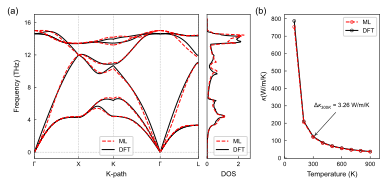

In [25]:
fig = plt.figure(figsize=(6, 2))
plt.subplots_adjust(left=0., right=1, top=1, bottom=0, wspace=0., hspace=0.)

grid = plt.GridSpec(1, 100, wspace=0., hspace=0., figure=fig)
ax1 = fig.add_subplot(grid[:, :38])
ax2 = fig.add_subplot(grid[:, 40:50])
ax3 = fig.add_subplot(grid[:, 58:80])

####### plot a: band #######
for dist, freq in zip(dist_ace, freq_ace):
    ax1.plot(dist, freq, 'r', linewidth=1, ls='--', label='ML')
for dist, freq in zip(dist_dft, freq_dft):
    ax1.plot(dist, freq, 'k', linewidth=1, label='DFT', zorder=0)
ax1.hlines(0, 0, labels_ticks_dft[-1], colors='silver', linestyles='--', lw=0.5)
for x in labels_ticks_dft:
    ax1.vlines(x, -0.75, 17, 'silver', linestyles='--', lw=0.5)
ax1.set_xticks(labels_ticks_dft)
ax1.set_xticklabels(labels)
ax1.set_xlim([0, labels_ticks_dft[-1]])
ax1.set_ylim(-0.75, 17)
ax1.set_yticks([0, 4, 8, 12, 16])
ax1.set_xlabel('K-path')
ax1.set_ylabel('Frequency (THz)')
ax1.legend([ax1.get_lines()[0], ax1.get_lines()[-1]], ['ML', 'DFT'])

####### plot a+: dos #######
ax2.plot(dos_ace['total_dos'], dos_ace['frequency_points'], 'r', lw=1, ls='--', label='ML')
ax2.plot(dos_dft['total_dos'], dos_dft['frequency_points'], 'k', lw=1, label='DFT', zorder=0)
ax2.hlines(0, 0, 3.5, colors='silver', linestyles='--', lw=0.5)
ax2.set_yticks([])
ax2.set_ylim(-0.75, 17)
ax2.set_xlim(0, 2.75)
ax2.set_xlabel('DOS')
ax2.legend(loc='lower right')

####### plot b: kappas #######
ax3.plot(temp_ace, kappa_ace, 'o--r', lw=1, ms=3, mfc='none', mew=0.5, label='ML')
ax3.plot(temp_dft, kappa_dft, 'o-k', lw=1, ms=3, mfc='none', mew=0.5, label='DFT', zorder=0)
ax3.set_xlim(0, 1000)
ax3.set_xticks([0, 300, 600, 900, ])
ax3.set_xlabel('Temperature (K)')
ax3.set_ylabel(r'$\kappa$(W/m/K)')
ax3.legend(loc='upper right')
ax3.annotate(r'$\Delta\kappa_{300K}$ ='+f' {abs((kappa_ace[2]-kappa_dft[2])).round(2)} W/m/K', 
             (300, kappa_ace[2]), (600, 300), 
             fontsize=6, ha='center', va='center', color='k', 
             arrowprops=dict(arrowstyle='->', lw=0.5)
)

ax1.text(-0.165, 1.05, '(a)', fontsize=9, va='top', ha='left', transform=ax1.transAxes, )
ax3.text(-0.31, 1.05, '(b)', fontsize=9, va='top', ha='left', transform=ax3.transAxes, )

# Case II: Amorphous carbon

## Step 1. Data collection

### A. AIMD for data pool

#### Build carbon bulk for melt-quench process

In [1]:
from ase.io import write
from ase.build import bulk

density = 2.5
a = (1*12.011 / (6.02e23) / density)**(1/3) * 1e8   # calculate the lattice constant given the density
C = bulk('C', 'sc', a)                              # create a simple cubic C structure     
C125 = C * [5, 5, 5]                                # create a 5x5x5 supercell, 125 atoms in total
write('./case2_Amorphous_Carbon/InitialDataCollection/POSCAR', C125, format='vasp')

#### AIMD
The DFT results (OUTCAR) are collected in `./case2_Amorphous_Carbon/InitialDataCollection/C125-traj.xyz`

The precalculated .xyz trajactory file can be fetched from remote with the following:

In [ ]:
!wget https://zenodo.org/records/14642844/files/case2_DFTtraj.zip
!unzip -nj case2_DFTtraj.zip -d ./case2_Amorphous_Carbon/InitialDataCollection
!mv ./case2_DFTtraj.zip ./cache

### B. Sample snapshots as initial dataset

In [9]:
from ase.io import read, write

MDtraj = read('./case2_Amorphous_Carbon/InitialDataCollection/C125-traj.xyz', format='extxyz', index=':')
step_int = 20                               # sample every step_int
dataset_MD = MDtraj[step_int-1::step_int]   # sample snapshots every step_int steps

os.system('mkdir -p ./case2_Amorphous_Carbon/QbC/iter1')
write('./case2_Amorphous_Carbon/QbC/iter1/dataset_iter1.xyz', dataset_MD, format='extxyz')

### C. Perform active learning (QbC)

The final dataset through the QbC progress can be fetched from remote with the following:

In [ ]:
!wget https://zenodo.org/records/14642844/files/case2_QbC.zip
!unzip -nj case2_QbC.zip -d ./case2_Amorphous_Carbon/QbC
!mv ./case2_QbC.zip ./cache

or run the following two blocks (which may consume several days)

In [2]:
def split_dataset(dataset, n):
    '''
    split dataset into n subsets (n trainsets and n corresponding testsets), detailed in Example as below:

    ----------------
    Parameter:
        dataset: list
            list of data to be devided  
        n: int
            devide dataset into n pieces  
    return:
        trainsets, testsets
    ----------------
    Example:
        dataset = [1~11], n = 5  \\
        set_1 = [ , 2, 3, 4, 5,  , 7, 8, 9,10,  ]   \\
        set_2 = [1,  , 3, 4, 5, 6,  , 8, 9,10,11]   \\
        set_3 = [1, 2,  , 4, 5, 6, 7,  , 9,10,11]   \\
        set_4 = [1, 2, 3,  , 5, 6, 7, 8,  ,10,11]   \\
        set_5 = [1, 2, 3, 4,  , 6, 7, 8, 9,  ,11]   \\
    '''
    num_data = len(dataset)
    trainsets, testsets = [], []
    for i in range(n):
        index_r = range(i, num_data, n)
        trainsets.append([dataset[j] for j in range(num_data) if j not in index_r])
        testsets.append([dataset[j] for j in range(num_data) if j in index_r])
    return trainsets, testsets

def write_dataset(dataset, path):
    '''
    write dataset to ACE readable format

    ----------------
    Parameter:
        dataset: list
            list of dataset  
        path: str
            path to save dataset    
    '''
    import pandas as pd    
    energy_list = [data.todict()['info']['energy'] for data in dataset]
    forces_list = [data.todict()['forces'] for data in dataset]
    data = {
        'energy': energy_list,
        'forces': forces_list,
        'ase_atoms': dataset,
        'energy_corrected': energy_list,
    }
    df = pd.DataFrame(data)

    df.to_pickle(path, compression='gzip', protocol=4)
    
def select_data(selected_index, uncertainties, num_select):
    '''
    select data index based on uncertainty. Each data is selected only once.

    ----------------
    Parameter:
        selected_index: list
            index of selected data
        uncertainties: list
            uncertainty of all data  
        num_select: int
            number of data to be newly selected
    return:
        index of newly selected data
    '''
    for i in range(len(uncertainties)):
        uncertainties[i] = 0. if i in selected_index else uncertainties[i]  # set selected data uncertainty to 0, so they won't be selected again.
        uncertainties[i] = 0. if i < 19 else uncertainties[i]               # set initial (cubic-like) data uncertainty to 0, so they won't be selected.
    index = np.argsort(uncertainties)[-num_select:]                         # select data with highest uncertainty
    index.sort()
    return list(index)

In [3]:
# this cell will take a long time to run (~ several days)
import os
import numpy as np
from p_tqdm import p_map
from ase.io import read, write
from pyace import PyACECalculator

import warnings
warnings.filterwarnings('ignore')

step_int = 20               # sample every step_int, which has been defined in the previous cell
num_committee = 8           # number of committees
num_iter = 10                # number of iteration
num_select_per_iter = 50    # number of data to be selected and added to dataset in each iteration

dataset_pool = read(f'./case2_Amorphous_Carbon/InitialDataCollection/C125-traj.xyz', format='extxyz', index=':')
selected_index = list(np.arange(len(dataset_pool))[step_int-1::step_int])       # initial selected data index, 500 data in total
dir = './case2_Amorphous_Carbon/QbC'
for iter in range(1, num_iter+1):
    print(f'------- Iteration {iter} -------')
    # build iteration directory
    os.system(f'mkdir -p ./case2_Amorphous_Carbon/QbC/iter{iter}')
    # build dataset
    dataset = [dataset_pool[index] for index in selected_index]
    write(f'{dir}/iter{iter}/dataset_iter{iter}.xyz', dataset, format='extxyz')
    trainsets, testsets = split_dataset(dataset, num_committee)
    # train committees
    for j in range(1, num_committee+1):
        if os.path.exists(f'{dir}/iter{iter}/committee{j}'): continue
        # write model hyperparameters by building committee directory
        os.system(f'cp -r {dir}/case0 {dir}/iter{iter}/committee{j}')
        # write dataset
        write_dataset(trainsets[j-1], f'{dir}/iter{iter}/committee{j}/trainset.pckl.gzip')
        write_dataset(testsets[j-1], f'{dir}/iter{iter}/committee{j}/testset.pckl.gzip')
        # train committee potential
        os.system(f'cd {dir}/iter{iter}/committee{j} && pacemaker input.yaml > /dev/null 2>&1')
    # estimate uncertainty of dataset
    calcs = [PyACECalculator(f'{dir}/iter{iter}/committee{j}/output_potential.yaml') for j in range(1, num_committee+1)]
    energy = []
    for calc in calcs:
        def predict(data): return calc.get_potential_energy(data)
        energy.append(p_map(predict, dataset_pool,))
    energy = np.array(energy)
    uncertainties = np.std(energy, axis=0)
    # select data with highest uncertainty
    index = select_data(selected_index, uncertainties, num_select_per_iter)
    selected_index += index
# write final dataset
dataset = [dataset_pool[index] for index in selected_index]
write(f'{dir}/dataset_final.xyz', dataset, format='extxyz')

------- Iteration 1 -------


100%|██████████| 10000/10000 [00:20<00:00, 485.52it/s]


------- Iteration 2 -------


100%|██████████| 10000/10000 [00:20<00:00, 481.62it/s]


------- Iteration 3 -------


100%|██████████| 10000/10000 [00:20<00:00, 481.53it/s]


------- Iteration 4 -------


100%|██████████| 10000/10000 [00:20<00:00, 487.21it/s]


------- Iteration 5 -------


100%|██████████| 10000/10000 [00:20<00:00, 486.96it/s]


------- Iteration 6 -------


100%|██████████| 10000/10000 [00:20<00:00, 493.09it/s]


------- Iteration 7 -------


100%|██████████| 10000/10000 [00:20<00:00, 491.22it/s]


------- Iteration 8 -------


100%|██████████| 10000/10000 [00:20<00:00, 487.25it/s]


------- Iteration 9 -------


100%|██████████| 10000/10000 [00:19<00:00, 509.04it/s]


------- Iteration 10 -------


100%|██████████| 10000/10000 [00:19<00:00, 506.74it/s]


## Step 2. ACE potential training

#### A. Prepare dataset

In [4]:
from ase.io import read
import pandas as pd

dataset = read('./case2_Amorphous_Carbon/QbC/dataset_final.xyz', ':')
print(dataset[0].todict().keys())
print(dataset[0].todict()['info'].keys())

energy_list = [data.todict()['info']['energy'] for data in dataset]
forces_list = [data.todict()['forces'] for data in dataset]

data = {
    'energy': energy_list,
    'forces': forces_list,
    'ase_atoms': dataset,
    'energy_corrected': energy_list,
}
df = pd.DataFrame(data)

df.to_pickle('./case2_Amorphous_Carbon/FinalMLIP/dataset.pckl.gzip', compression='gzip', protocol=4)

dict_keys(['numbers', 'positions', 'forces', 'cell', 'pbc', 'info'])
dict_keys(['energy', 'free_energy', 'MDstep'])


#### B. Train
The pretrained ACE potential can be fetched from remote with the following:

In [ ]:
!wget https://zenodo.org/records/14642844/files/case2_ACEmodel.zip
!unzip -nj case2_ACEmodel.zip -d ./case2_Amorphous_Carbon/FinalMLIP
!mv ./case2_ACEmodel.zip ./cache

## Step 3. Thermal properties calculation

### A. Perform melt-quench process for a-C "prototypes"

In [7]:
import os
from ase.io import read, write

# build lammps potential file
os.system(f'pace_yaml2yace ./case2_Amorphous_Carbon/FinalMLIP/output_potential.yaml -o ./case2_Amorphous_Carbon/MeltQuench/ACE/aC.yace')

# build lammmps data file
atoms = read('./case2_Amorphous_Carbon/InitialDataCollection/POSCAR', format='vasp')
os.system(f'mkdir -p ./case2_Amorphous_Carbon/MeltQuench/ACE')
write('./case2_Amorphous_Carbon/MeltQuench/ACE/cubicC.data', atoms, format='lammps-data')

Loading B-basis from './case2_Amorphous_Carbon/FinalMLIP/output_potential.yaml'
Converting to Ctilde-basis
Saving Ctilde-basis to './case2_Amorphous_Carbon/MeltQuenchACE/aC.yace'


Leveraging the ACE potential, we can run the melt-quench process using LAMMPS with input shown in `./case2_Amorphous_Carbon/MeltQuench/melt-quench.in`

The precalculated a-C structure can be fetched from remote with the following:

In [ ]:
!wget https://zenodo.org/records/14642844/files/case2_aC_gen.zip
!unzip -nj case2_aC_gen.zip -d ./case2_Amorphous_Carbon/MeltQuench
!mv ./case2_aC_gen.zip ./cache

### B. Get force constants
see `./case2_Amorphous_Carbon/Dyn`

The precalculated force constants can be fetched from remote with the following (The zip package is 9 GB and unzip to over 35 GB):

In [ ]:
!wget https://zenodo.org/records/14642844/files/case2_FCs.zip
!unzip -nj case2_FCs.zip -d ./case2_Amorphous_Carbon/Dyn
!mv ./case2_FCs.zip ./cache

### C. Calculate kappa

the key results from running the QHGK for thermal conductivity can be fetched from remote with the following:

In [ ]:
!wget https://zenodo.org/records/14642844/files/case2_kappa.zip
!unzip -n case2_kappa.zip -d ./case2_Amorphous_Carbon/ThermalConductivity
!mv ./case2_kappa.zip ./cache

!mv ./case2_Amorphous_Carbon/ThermalConductivity/case2_kappa/* ./case2_Amorphous_Carbon/ThermalConductivity
!rm -r ./case2_Amorphous_Carbon/ThermalConductivity/case2_kappa

or run the following two blocks (which may consume about one day). The package kaldo is required for these two blocks, which can be installed with [this site](https://nanotheorygroup.github.io/kaldo/docsource/getting_started.html).

In [ ]:
import numpy as np
from ase.atoms import Atoms
from ase.io import read, write

# transfer a-C structure from lammps data to dlp4 format
atoms = read('./case2_Amorphous_Carbon/MeltQuench/aC-opt.data', format='lammps-data', style='atomic')
index = np.argsort(atoms.todict()['id'])
atoms_re = Atoms(
    numbers=[6]*len(atoms),
    positions=atoms.get_positions()[np.array(index)],   # sort atoms by id
    cell=atoms.get_cell(),
    pbc=atoms.get_pbc(),
)
write('./case2_Amorphous_Carbon/Dyn/CONFIG', atoms_re, format='dlp4')

In [ ]:
from kaldo.phonons import Phonons
from kaldo.conductivity import Conductivity
from kaldo.forceconstants import ForceConstants

# Read amporphous silicon with eskm format
forceconstants = ForceConstants.from_folder(folder='./case2_Amorphous_Carbon/Dyn', format='eskm', )

# Create a phonon object
phonons = Phonons (forceconstants=forceconstants,
                   is_classic=0,
                   temperature=300,
                   folder='./case2_Amorphous_Carbon/ThermalConductivity',
                   third_bandwidth=0.01,
                   broadening_shape='triangle',
                   storage='numpy')

# calculate thermal conductivity. This may occupy a lot of memory (> 64 GB)
frequency = phonons.frequency.flatten(order='C')
bandwidth = phonons.bandwidth.flatten(order='C')
phase_space = phonons.phase_space.flatten(order='C')
TC = Conductivity(phonons=phonons, method='qhgk',n_iterations=20)

#### Plot

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['arial']     
plt.rcParams['mathtext.fontset'] = 'custom'     # (default: 'dejavusans')
plt.rcParams['font.weight'] = 'regular'

plt.rcParams['axes.titlesize'] = 8      # title
plt.rcParams['axes.labelsize'] = 7      # axis label
plt.rcParams['legend.fontsize'] = 6     # legend
plt.rcParams['xtick.labelsize'] = 6     # x-axis tick font size
plt.rcParams['ytick.labelsize'] = 6     # y-axis tick font size

# tick
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 2        # line length of axis tick
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.major.width'] = 0.5     # line width of axis tick
plt.rcParams['ytick.major.width'] = 0.5     

# line
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.unicode_minus'] = False  # display negative sign

# output
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.format'] = 'svg'
plt.rcParams['figure.autolayout'] = False

# polt in svg format
%config InlineBackend.figure_format = 'svg'

In [21]:
import numpy as np

result_dir = './case2_Amorphous_Carbon/ThermalConductivity'
# load frequency and bandwidth
freq = np.load(f'{result_dir}/frequency.npy').squeeze()
bandwidth = np.load(f'{result_dir}/300/quantum/tb_0.01/bandwidth.npy').squeeze()
# load thermal conductivity
kappa_00 = np.loadtxt(f'{result_dir}/300/quantum/tb_0.01/qhgk/conductivity_0_0.dat',)
kappa_11 = np.loadtxt(f'{result_dir}/300/quantum/tb_0.01/qhgk/conductivity_1_1.dat',)
kappa_22 = np.loadtxt(f'{result_dir}/300/quantum/tb_0.01/qhgk/conductivity_2_2.dat',)
kappa = np.mean([kappa_00, kappa_11, kappa_22], axis=0)
kappa_cum = np.cumsum(kappa)

1.3555701034938157

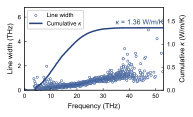

In [32]:
fig = plt.figure(figsize=(2.5, 1.5))
ax1 = fig.add_subplot(111)

kappa = kappa_cum[-1]

# plot line width
ax1.scatter(freq, bandwidth, label='Bandwidth', lw=0.5, s=5, ec='#2b4f8f', c='w')
ax1.set_ylim(0, 6.8)
ax1.set_ylabel(r'Line width (THz)')

# plot cummulative kappa 
ax2 = ax1.twinx()
ax2.plot(freq, kappa_cum, label='Kappa', c='#27447c')
ax2.text(53, 1.4, f'$\kappa$ = {kappa_cum[-1].__round__(2)} W/m/K', fontsize=7, ha='right', va='bottom', color='#27447c')
ax2.set_ylim(0, 1.8)
ax2.set_ylabel(r'Cumulative $\kappa$ (W/m/K)')

# settings
ax1.set_xlim(0, 55)
ax1.set_xlabel('Frequency (THz)')
ax1.legend([ax1.get_children()[0], ax2.get_children()[0]], ['Line width', r'Cumulative $\kappa$'], loc='upper left')
for ax in [ax1, ax2]:
    ax.set_xlim(0, 55)